# Group 14 - Project FP01
## Time series anomaly detection - Autoencoder

This project aims at investigating the current state-of-the-arts TAD scenario.

In [5]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [6]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [7]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [8]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [9]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 96.00540137290955 seconds ---


In [10]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


## AutoEncoder

In [11]:
from algorithms.autoencoder import AutoEncoder

classifier = AutoEncoder(
    name='AutoEncoder',
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    hidden_size=32,
    sequence_length=5,
    train_gaussian_percentage=0.25,
    seed=42,
    gpu=None,
    details=True
)

# Train the AutoEncoder on normal data
classifier.fit(X_train)

print("AutoEncoder training completed.")

100%|██████████| 100/100 [00:12<00:00,  7.76it/s]

AutoEncoder training completed.


### Anomaly Detection

Anomaly prediction completed.


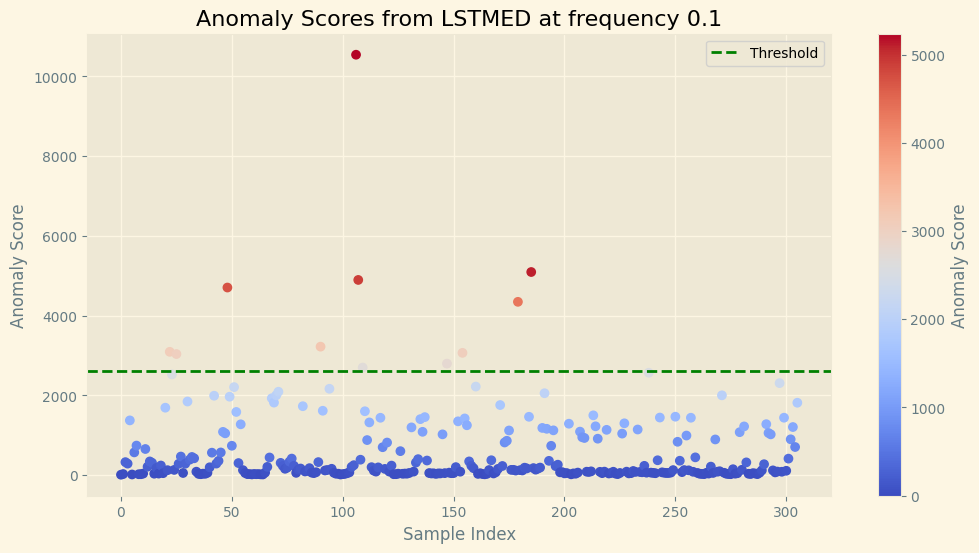

Number of anomalies detected: 11


In [12]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)

In [13]:
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, y_test)

Anomaly scores statistics:
Mean: 589.3111097625385
Std: 1014.4529317846738
Min: 10.02131121129272
Max: 10546.025534180424
ROC AUC Score: 0.7262
Detected anomaly class: 2
Threshold: 2618.2170
F1 Score: 0.2000
Accuracy: 0.9477
Precision: 0.1818
Recall: 0.2222
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       297
           1       0.18      0.22      0.20         9

    accuracy                           0.95       306
   macro avg       0.58      0.60      0.59       306
weighted avg       0.95      0.95      0.95       306



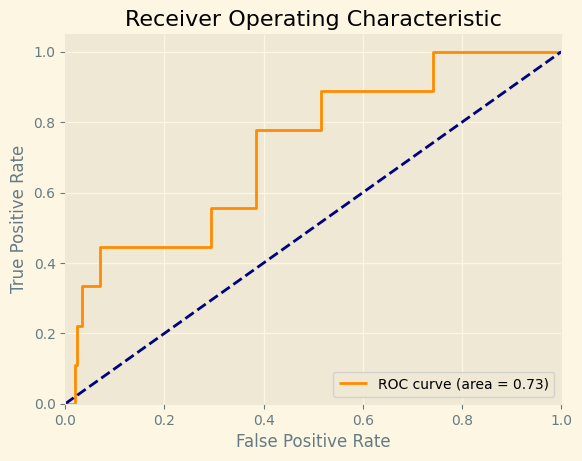

In [14]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

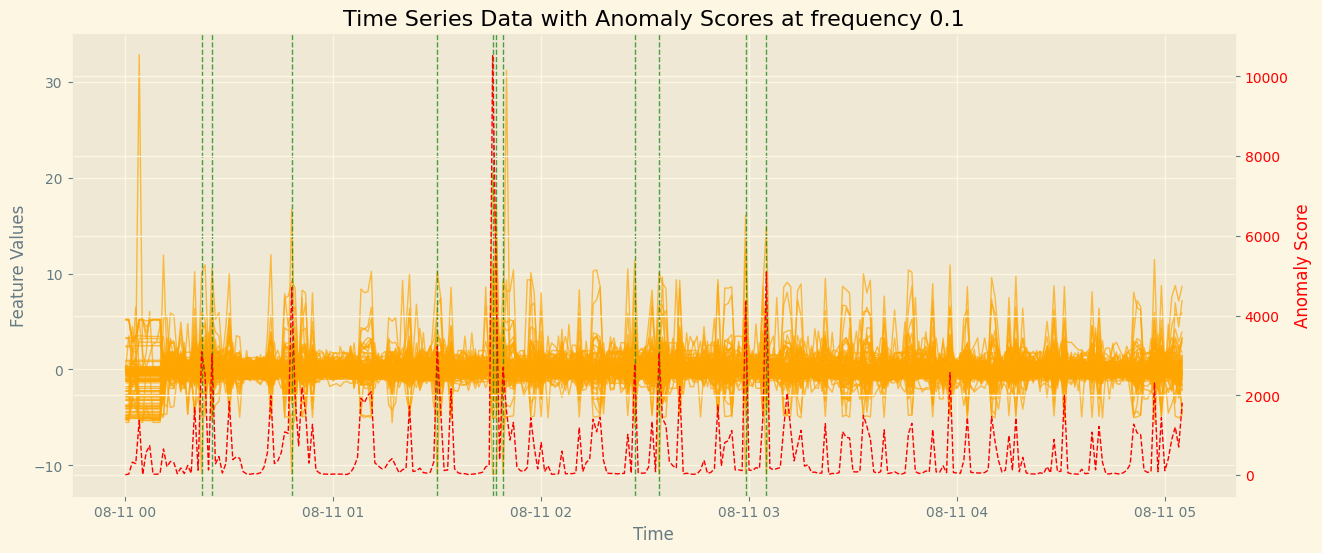

Top 11 Anomalies:
              timestamp  anomaly_score  \
106 2022-08-11 01:46:00   10546.025534   
185 2022-08-11 03:05:00    5095.157220   
107 2022-08-11 01:47:00    4896.284549   
48  2022-08-11 00:48:00    4705.964559   
179 2022-08-11 02:59:00    4347.248185   
90  2022-08-11 01:30:00    3222.816118   
22  2022-08-11 00:22:00    3093.014574   
154 2022-08-11 02:34:00    3067.202807   
25  2022-08-11 00:25:00    3037.606298   
147 2022-08-11 02:27:00    2797.311742   
109 2022-08-11 01:49:00    2698.211489   

     machine_nameKuka Robot_apparent_power-_Average power  \
106                                          -1.885449      
185                                          -1.065886      
107                                          -1.181816      
48                                           -0.707436      
179                                          -1.338344      
90                                           -1.115056      
22                                           -0.82

In [16]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)